In [1]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees

# Max-tree and attribute filtering

![](img/max_pruning.png)

## 0. Setup: Load the DSM tile

- Load the dsm tile `tile_path` 

In [2]:
tile_path = Path('data/dsm_vox_50cm_tile_-12_0.tif')
with rio.open(tile_path) as src:
    dsm_array = src.read(1)   # 
    nodata = src.nodata

#dsm = None # Your turn!
dsm = dsm_array.astype(float)
if nodata is not None:
    dsm[dsm == nodata] = np.nan


In [3]:
dsm

array([[29.14522362, 29.12707138, 29.12030602, ..., 50.74575806,
        53.14151001, 52.86373901],
       [29.15999985, 29.14166641, 29.12333298, ..., 48.76499939,
        53.90000153, 53.89113617],
       [30.58499908, 29.96999931, 29.1060009 , ..., 50.56999969,
        54.59500122, 54.25640488],
       ...,
       [43.56499863, 43.5357132 , 43.56000137, ..., 48.31000137,
        48.5233345 , 45.38999939],
       [43.12769318, 43.15545273, 43.16583252, ..., 46.95000076,
        47.23249817, 45.83927155],
       [42.95999908, 42.69428635, 43.        , ..., 46.06000137,
        47.11000061, 46.53666687]], shape=(2001, 2001))

In [4]:
dsm_no_nan = np.copy(dsm) 
dsm_no_nan[np.isnan(dsm_no_nan)] = np.nanmin(dsm) - 1 # replace NaNs with a value lower than the minimum


In [5]:
dsm_no_nan

array([[29.14522362, 29.12707138, 29.12030602, ..., 50.74575806,
        53.14151001, 52.86373901],
       [29.15999985, 29.14166641, 29.12333298, ..., 48.76499939,
        53.90000153, 53.89113617],
       [30.58499908, 29.96999931, 29.1060009 , ..., 50.56999969,
        54.59500122, 54.25640488],
       ...,
       [43.56499863, 43.5357132 , 43.56000137, ..., 48.31000137,
        48.5233345 , 45.38999939],
       [43.12769318, 43.15545273, 43.16583252, ..., 46.95000076,
        47.23249817, 45.83927155],
       [42.95999908, 42.69428635, 43.        , ..., 46.06000137,
        47.11000061, 46.53666687]], shape=(2001, 2001))

## 1. Create the max-tree of the DSM with the Python package `sap`

- Create the max-tree of `dsm` (tip: don't forget that you can display docstrings with `?<package>`!)
- How many nodes have the max-tree?

In [7]:
# Your turn!

t = sap.MaxTree(dsm_no_nan) # create max-tree
area = t.get_attribute("area") # compute area attribute
filtered_image = t.reconstruct(area < 100) # filter by area<100

## print number of nodes before and after filtering
print(f"Number of nodes: {t.num_nodes}")


Number of nodes: <bound method Tree.num_nodes of MaxTree{'adjacency': 4,
 'image.dtype': dtype('float64'),
 'image.shape': (2001, 2001),
 'image_hash': 'f0eb33b2',
 'image_name': None,
 'num_nodes': 6119633}>


In [8]:
dsm_no_nan.dtype

dtype('float64')

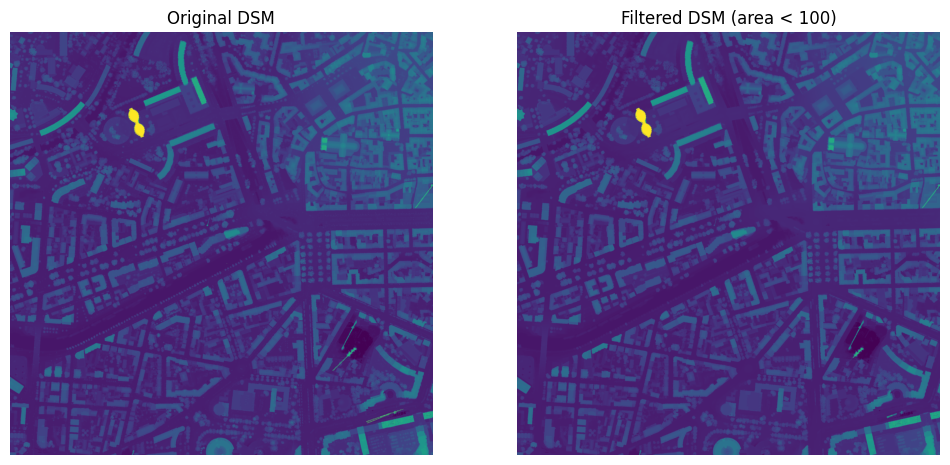

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(dsm_no_nan, cmap="viridis")
plt.title("Original DSM")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap="viridis")
plt.title("Filtered DSM (area < 100)")
plt.axis("off")
plt.show()

In [18]:
! pip show sap

Name: sap
Version: 1.0.0
Summary: Simple Attribute Profiles
Home-page: https://github.com/fguiotte/sap
Author: Florent Guiotte
Author-email: florent@guiotte.fr
License: 
Location: /Users/saharmohamed/miniforge3/envs/sap_env/lib/python3.11/site-packages
Requires: higra, matplotlib, numpy, tqdm
Required-by: 


## 2. Compute some attributes on the max-tree

- Get the nodes `area` attribute in a vector.
- Get the nodes `compactness` attributes.
- What is the size of the attribute vectors? Why?

In [10]:
# Your turn!
import higra as hg
area = t.get_attribute("area")
compacteness = t.get_attribute("compactness")
#filtered_image = t.reconstruct((area < 100) & (compacteness > 0.5))


## print size of attributes
print(f"Area attribute size: {area.size}")
print(f"Compactness attribute size: {compacteness.size}")

# Build the leaf graph of pixels (4-connected) for compactness computation
# leaf_graph = hg.get_4_adjacency_graph(dsm_no_nan.shape)
# # Compute compactness
# compactness_higra = hg.attribute_compactness(t, leaf_graph=leaf_graph)
# print(f"Compactness size: {compactness_higra.size}")

## print first 10 values of compactness
print("First 10 values of compactness attribute:")
print(compacteness[:30])
print(area[:30])



Area attribute size: 6119633
Compactness attribute size: 6119633
First 10 values of compactness attribute:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


## 3. Filter the DSM with attribute filtering!

We'll filter the DTM with a threshold on the area attributes.

+ Choose an area threshold
+ Get the vector of deleted nodes
+ Filter the tree according to the vector of deleted nodes
+ Display!

Number of deleted nodes: [ 16.93000031  16.93088722  16.9309864  ... 118.26844025 118.26856995
 118.26863098]


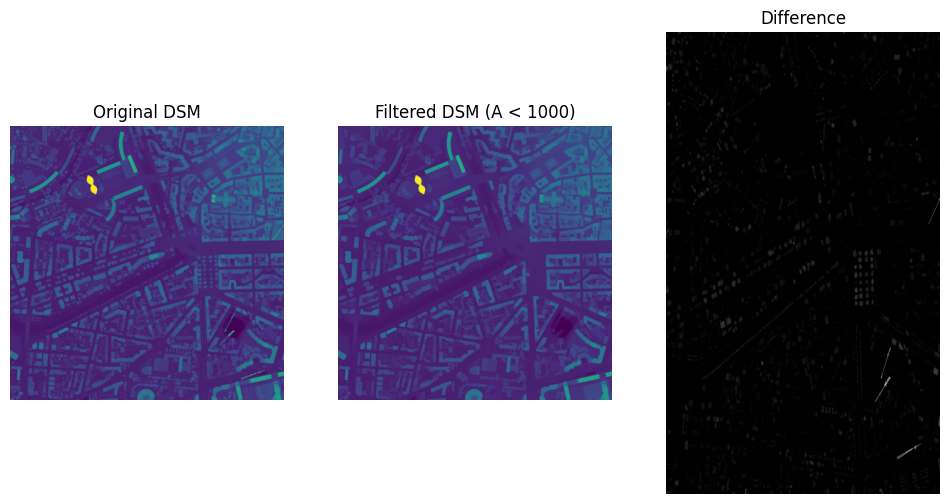

In [21]:
# Your turn!
area_th = 1000
deleted_nodes = area < area_th
filtered_image = t.reconstruct(deleted_nodes)
## print vector of deleted nodes
print(f"Number of deleted nodes: {np.unique(filtered_image)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(dsm, cmap="viridis")
plt.title("Original DSM")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(filtered_image, cmap="viridis")
plt.title("Filtered DSM (A < 1000)")
plt.axis("off")
plt.subplot (1, 3, 3)
plt.imshow(dsm - filtered_image, cmap="gray", aspect="auto")
plt.title("Difference")
plt.axis("off")
plt.show()



In [22]:
print(filtered_image)

[[29.12999916 29.12707138 29.12030602 ... 48.62290192 48.62290192
  48.62290192]
 [29.12999916 29.12999916 29.12333298 ... 48.62290192 48.62290192
  48.62290192]
 [29.12999916 29.12999916 29.1060009  ... 48.62290192 48.62290192
  48.62290192]
 ...
 [32.45000076 32.45000076 32.45000076 ... 39.27999878 39.27999878
  39.27999878]
 [32.45000076 32.45000076 32.45000076 ... 39.27999878 39.27999878
  39.27999878]
 [32.45000076 32.45000076 32.45000076 ... 39.27999878 39.27999878
  39.27999878]]


In [25]:

print(deleted_nodes)

[False False False ...  True  True  True]


## DRAFT


Number of deleted nodes: [False  True]


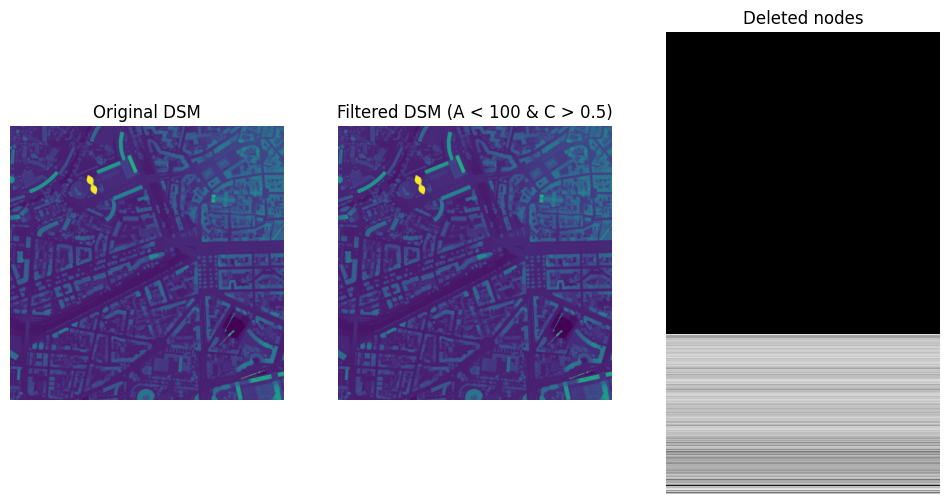

In [17]:
# Your turn!
## filter dsm by area<100 and compactness>0.5
filtered_image = t.reconstruct((area < 100) & (compacteness > 0.5))

## print vector of deleted nodes
deleted_nodes = (area >= 100) | (compacteness <= 0.5)
print(f"Number of deleted nodes: {np.unique(deleted_nodes)}")

## Filter the tree according to the vector of deleted nodes
filtered_image = t.reconstruct(~deleted_nodes)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(dsm, cmap="viridis")
plt.title("Original DSM")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(filtered_image, cmap="viridis")
plt.title("Filtered DSM (A < 100 & C > 0.5)")
plt.axis("off")
plt.subplot (1, 3, 3)
plt.imshow(deleted_nodes.reshape(t.num_nodes(), 1), cmap="gray", aspect="auto")
plt.title("Deleted nodes")
plt.axis("off")
plt.show()

